##### code reference: https://github.com/nicknochnack/BERTSentiment/blob/main/Sentiment.ipynb
##### pre-trained model employed: https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment

In [1]:
import re
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import csv
import collections
from matplotlib import pyplot as plt

2022-05-20 22:49:49.215162: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-20 22:49:49.215213: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
DATA_DIR = "../speeches"
RESULTS_DIR = "../speeches/results/sentiment_analysis"

#### Instantiate Model

In [3]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cpu


#### Import data from csv

In [50]:
i = 1

month_to_num = {}
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

for month in months:
    if i < 10:
        month_to_num[month] = "0" + str(i)
    else:
        month_to_num[month] = str(i)
    i += 1

In [6]:
mann_ki_baat = {}

with open( DATA_DIR + "/mann_ki_baat.csv", "r", encoding="utf-8", newline="") as file:
    reader = csv.reader(file, delimiter="|")
    for row in reader:
        date = row[1].split(',')[1].strip() + month_to_num[row[1].split(' ')[1].strip(',')] + row[1].split(' ')[0]
        mann_ki_baat[date] = row[2]

In [7]:
data = []

od_mann_ki_baat = collections.OrderedDict(sorted(mann_ki_baat.items()))

for key in od_mann_ki_baat.keys():
    data.append([key, od_mann_ki_baat[key]])

#### Perform Sentiment Analysis

In [9]:
df = pd.DataFrame(np.array(data), columns = ['date', 'speech'])
df.head()

,date,speech
0,20141003,"My Dear Countrymen, Today is the holy festival..."
1,20141102,"My dear fellow countrymen, I am with you agai..."
2,20141214,"My Dear Fellow Countrymen, Today I have this g..."
3,20150127,"Today, Shri Barack Obama, President of the Uni..."
4,20150222,"Hello, my young friends. Today probably the en..."


In [10]:
def sentiment_score(speech):
    tokens = tokenizer.encode(speech, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [11]:
MAX_PASS = 512
score_arr = []
final_score = 0

In [29]:
for index, row in df.iterrows():

    speech = row['speech']
    length = len(speech)
    no_of_iterations = int(length / MAX_PASS)
    leftover = length % MAX_PASS
    final_score = 0

    for i in range(no_of_iterations):

        begin = i * MAX_PASS
        end = begin + MAX_PASS

        score = sentiment_score(speech[begin:end])
        final_score += score

    begin = (i+1) * MAX_PASS
    end = begin + leftover

    score = sentiment_score(speech[begin:end])
    final_score += score

    final_score /= (no_of_iterations + 1)

    score_arr.append(final_score)

In [31]:
df.insert(2, "score", np.array(score_arr), True)
df.head()

,date,speech,score
0,20141003,"My Dear Countrymen, Today is the holy festival...",4.045455
1,20141102,"My dear fellow countrymen, I am with you agai...",3.720000
2,20141214,"My Dear Fellow Countrymen, Today I have this g...",3.621622
3,20150127,"Today, Shri Barack Obama, President of the Uni...",4.425000
4,20150222,"Hello, my young friends. Today probably the en...",3.714286


#### Plot Sentiment score against Month

In [48]:
months_arr = []

for item in data:
    date = item[0]
    month = date[4:6] + "/" + date[2:4]
    months_arr.append(month)

Text(0, 0.5, 'Sentiment Score')

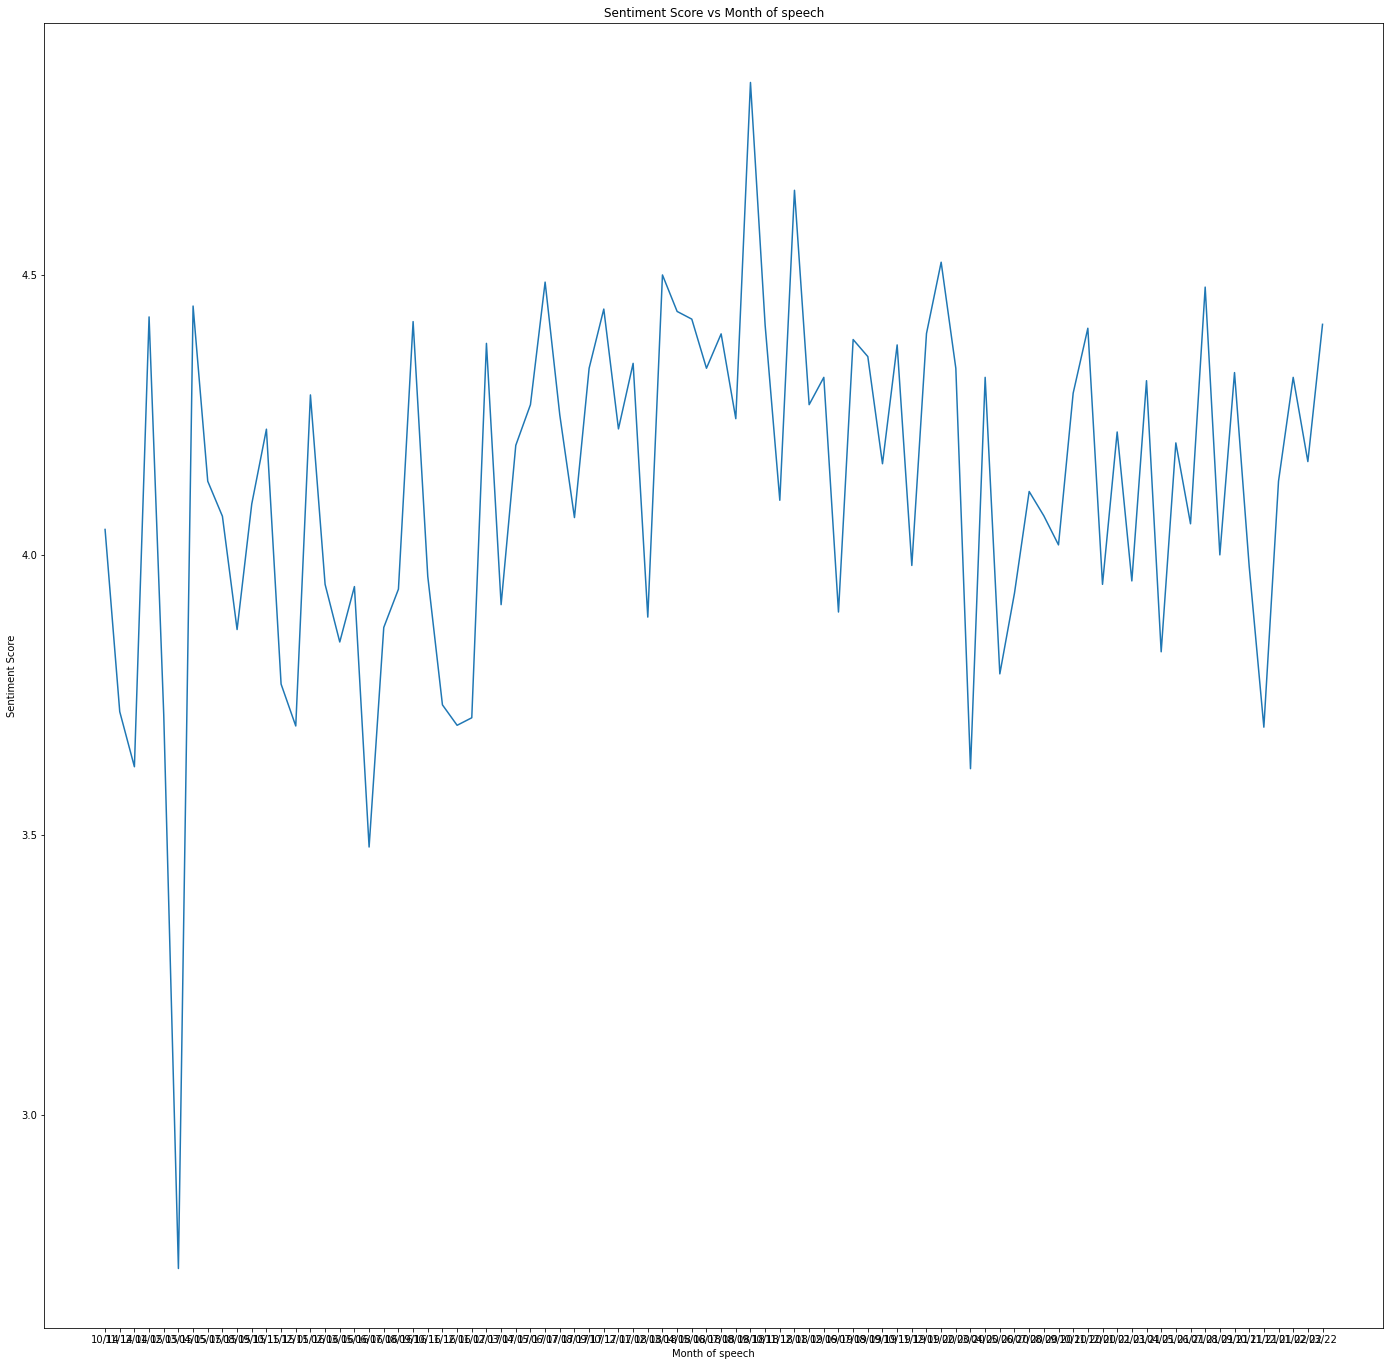

In [49]:
plt.figure(figsize=[24, 24])
plt.plot(months_arr, score_arr)
plt.title('Sentiment Score vs Month of speech')
plt.xlabel('Month of speech')
plt.ylabel('Sentiment Score')

#### Write results into file

In [52]:
with open (RESULTS_DIR + "/scores.txt", "w") as f:
    for index, row in df.iterrows():
        date = row['date']
        month = date[4:6] + "/" + date[2:4]
        score = row['score']
        f.write(month + " : " + str(score) + "\n")

In [16]:
with open(RESULTS_DIR + "/scores.txt", "r") as f:
    scores = f.read().split("\n")

avg_score = 0

for row in scores:
    avg_score += float(row.split(" ")[2])

avg_score /= 84 # NO_OF_SPEECHES = 84

print("Average sentiment score : " + str(avg_score))

Average sentiment score : 4.119514202122193
